# Adaptive Cruise Control

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]'

In [3]:
from cbf_opt import ControlAffineDynamics, ControlAffineCBF, ControlAffineASIF
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np
import seaborn as sns
import os
import sys
sys.path.insert(1, '../../refineCBF')
import refine_cbfs
import matplotlib as mpl

## Setup Problem (dynamics, environment and CBF)

Dynamics of the Adaptive Cruise Control problem (control affine), in the format of `cbf_opt`

`ACC_JNP_Dynamics` is required for usage with `hj_reachability` module

In [4]:
class ACCDynamics(ControlAffineDynamics):
    STATES = ['P', 'V', 'dP'] # position, velocity, distance between cars
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[..., 1] + self.f2 * x[..., 1] ** 2
        self.v0 = params["v0"]
        super().__init__(params, **kwargs)

    def state_jacobian(self, state, control, time=0.):
        J = np.repeat(np.zeros_like(state)[..., None], self.n_dims, axis=-1)
        J[..., 0, 1] = 1
        J[..., 1, 1] = -1 / self.mass * (self.f1 + 2 * self.f2 * state[..., 1])
        J[..., 2, 1] = -1 
        return J
        
    def open_loop_dynamics(self, state, time=0.):
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = -1 / self.mass * self.rolling_resistance(state)
        f[..., 2] = self.v0 - state[..., 1]
        return f

    def control_matrix(self, state, time=0.):
        B = np.repeat(np.zeros_like(state)[..., None], self.control_dims, axis=-1)
        B[..., 1, 0] = 1 / self.mass 
        return B


class ACCJNPDynamics(ACCDynamics):
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1 / self.mass, 0]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

Setting up the Dynamics with specific parameter instantiation

In [5]:
params_dry = dict()
params_dry["dt"] = 0.01
params_dry["g"] = 9.81
params_dry['v0'] = 14  # lead vehicle velocity
params_dry['f0'] = 0.1 * 3  # friction coefficient
params_dry['f1'] = 5 * 3  # friction coefficient
params_dry['f2'] = 0.25 * 3  # friction coefficient
params_dry['mass'] = 1650  # vehicle mass

acc_dry = ACCDynamics(params_dry)
acc_jnp_dry = ACCJNPDynamics(params_dry)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
params_ice = dict()
params_ice["dt"] = 0.01
params_ice["g"] = 9.81
params_ice['v0'] = 14  # lead vehicle velocity
params_ice['f0'] = 0.1  # friction coefficient
params_ice['f1'] = 5  # friction coefficient
params_ice['f2'] = 0.25  # friction coefficient
params_ice['mass'] = 1650  # vehicle mass

acc_ice = ACCDynamics(params_ice)
acc_jnp_ice = ACCJNPDynamics(params_ice)

## Initial Control Barrier Function
Below is a candidate CBF (safe, but overly conservative) for the problem. This is the optimal CBF when neglecting friction (but it does account for limited actuation).

In [12]:
## counter example, at switching surface, let z = 70, v = 24, v0 = 14

In [7]:
class ACCCBF(ControlAffineCBF):
    def __init__(self, dynamics, params, cd_limit, **kwargs):
        self.Th = params["Th"]
        self.cd = cd_limit
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=None):
        return state[..., 2] - self.Th * state[..., 1] - (state[..., 1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    def _grad_vf(self, state, time=None):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 1] = - self.Th  - (state[..., 1] - self.dynamics.v0) / (self.cd * self.dynamics.g)
        dvf_dx[..., 2] = 1.0
        return dvf_dx

Setting up the CBF with specific parameter instantiation

In [8]:
cbf_params = dict()
cbf_params["Th"] = 1.8
control_limit_dry = 0.3
control_limit_ice = 0.1

acc_cbf_dry = ACCCBF(acc_dry, cbf_params, control_limit_dry)
acc_jnp_cbf_dry = ACCCBF(acc_jnp_dry, cbf_params, control_limit_dry)

umax_dry = np.array([control_limit_dry * params_dry['mass'] * params_dry['g']])
umin_dry = -umax_dry

acc_cbf_ice = ACCCBF(acc_ice, cbf_params, control_limit_ice)
acc_jnp_cbf_ice = ACCCBF(acc_jnp_ice, cbf_params, control_limit_ice)

umax_ice = np.array([control_limit_ice * params_ice['mass'] * params_ice['g']])
umin_ice = -umax_ice

In [9]:
print(umax_dry, umax_ice)

[4855.95] [1618.65]


Setting maximal and minimal control effort

### Environment

In [10]:
dyn_reachability_jnp_dry = refine_cbfs.HJControlAffineDynamics(acc_jnp_dry, control_space=hj.sets.Box(jnp.array(umin_dry), jnp.array(umax_dry)))
dyn_reachability_dry = refine_cbfs.HJControlAffineDynamics(acc_dry, control_space=hj.sets.Box(jnp.array(umin_dry), jnp.array(umax_dry)))

dyn_reachability_jnp_ice = refine_cbfs.HJControlAffineDynamics(acc_jnp_ice, control_space=hj.sets.Box(jnp.array(umin_ice), jnp.array(umax_ice)))
dyn_reachability_ice = refine_cbfs.HJControlAffineDynamics(acc_ice, control_space=hj.sets.Box(jnp.array(umin_ice), jnp.array(umax_ice)))

low_bound = jnp.array([0., 10., 0.])
high_bound = jnp.array([500, 40., 100.])
nbr_pts = (101, 101, 101)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)
grid_np = refine_cbfs.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

In [11]:
print(grid.states[..., 0].shape)
#print(grid.states[0, 0, 0, 2])

(101, 101, 101)


In [12]:
obstacle_dry = grid.states[..., 2] - acc_cbf_dry.Th * grid.states[..., 1]
obstacle_ice = grid.states[..., 2] - acc_cbf_ice.Th * grid.states[..., 1]

In [13]:
assert obstacle_dry.all() == obstacle_ice.all()

In [14]:
print(obstacle_dry[2, 0, 0])

-18.0


In [15]:
print(obstacle_ice.shape)

(101, 101, 101)


## Refining the CBF using Dynamic Programming

In [13]:
acc_tabular_cbf_dry = refine_cbfs.TabularControlAffineCBF(acc_dry, dict(), grid=grid)
acc_jnp_tabular_cbf_dry = refine_cbfs.TabularControlAffineCBF(acc_jnp_dry, dict(), grid=grid)

acc_tabular_cbf_dry.tabularize_cbf(acc_cbf_dry)
acc_jnp_tabular_cbf_dry.tabularize_cbf(acc_jnp_cbf_dry)

acc_tabular_cbf_ice = refine_cbfs.TabularControlAffineCBF(acc_ice, dict(), grid=grid)
acc_jnp_tabular_cbf_ice = refine_cbfs.TabularControlAffineCBF(acc_jnp_ice, dict(), grid=grid)

acc_tabular_cbf_ice.tabularize_cbf(acc_cbf_ice)
acc_jnp_tabular_cbf_ice.tabularize_cbf(acc_jnp_cbf_ice)

In [14]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle_ice))
# solver_settings = hj.SolverSettings.with_accuracy("medium",
#                                                   value_postprocessor=hj.solver.backwards_reachable_tube)
init_value = acc_jnp_tabular_cbf_ice.vf_table
print(init_value.shape)

(101, 101, 101)


In [15]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
# unsafe set: the last value is negative
target_values_hjr_ice = hj.solve(solver_settings, dyn_reachability_jnp_ice, grid, times, obstacle_ice)
target_values_ice = hj.solve(solver_settings, dyn_reachability_jnp_ice, grid, times, init_value)

  7%|6         |  1.3754/20.0 [00:04<01:00,  3.26s/sim_s]

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py(1988): _wrapped_callback
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(1229): __call__
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/profiler.py(314): wrapper
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1148): _pjit_call_impl_python
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1192): call_impl_cache_miss
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1209): _pjit_call_impl
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/core.py(821): process_primitive
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/core.py(389): bind_with_trace
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/core.py(2596): bind
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(166): _python_pjit_helper
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(253): cache_miss
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/traceback_util.py(166): reraise_with_filtered_traceback
  /tmp/ipykernel_12249/4128077192.py(5): <module>
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3526): run_code
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3466): run_ast_nodes
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3284): run_cell_async
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3079): _run_cell
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3024): run_cell
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py(546): run_cell
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py(422): do_execute
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(740): execute_request
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(412): dispatch_shell
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(505): process_one
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(516): dispatch_queue
  /usr/lib/python3.10/asyncio/events.py(80): _run
  /usr/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /usr/lib/python3.10/asyncio/base_events.py(603): run_forever
  /home/shuo/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py(195): start
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py(736): start
  /home/shuo/.local/lib/python3.10/site-packages/traitlets/config/application.py(1043): launch_instance
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /usr/lib/python3.10/runpy.py(86): _run_code
  /usr/lib/python3.10/runpy.py(196): _run_module_as_main


In [27]:
# save data
with open("../../../dataset/acc-data/target_values_ice_100.npy", "wb") as f:
    jnp.save(f, target_values_ice)
with open("../../../dataset/acc-data/target_values_hjr_ice_100.npy", "wb") as f:
    jnp.save(f, target_values_hjr_ice)

In [28]:
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle_dry))
init_value_dry = acc_jnp_tabular_cbf_dry.vf_table
target_values_hjr_dry= hj.solve(solver_settings, dyn_reachability_jnp_dry, grid, times, obstacle_dry)
target_values_dry = hj.solve(solver_settings, dyn_reachability_jnp_dry, grid, times, init_value_dry)

100%|##########| 20.0000/20.0 [01:12<00:00,  3.64s/sim_s]
100%|##########| 20.0000/20.0 [01:13<00:00,  3.68s/sim_s]


In [29]:
# save data
with open("../../../dataset/acc-data/target_values_dry_100.npy", "wb") as f:
    jnp.save(f, target_values_dry)
with open("../../../dataset/acc-data/target_values_hjr_dry_100.npy", "wb") as f:
    jnp.save(f, target_values_hjr_dry)

In [16]:
# read data
with open("../../../dataset/acc-data/target_values_dry_100.npy", "rb") as f:
    target_values_dry = jnp.load(f)
with open("../../../dataset/acc-data/target_values_hjr_dry_100.npy", "rb") as f:
    target_values_hjr_dry = jnp.load(f)
with open("../../../dataset/acc-data/target_values_ice_100.npy", "rb") as f:
    target_values_ice = jnp.load(f)
with open("../../../dataset/acc-data/target_values_hjr_ice_100.npy", "rb") as f:
    target_values_hjr_ice = jnp.load(f)

In [16]:
print(target_values_dry[-1][20][42][45])
print(target_values_ice[-1][20][42][45])


3.317253
-15.562919


In [17]:
assert jnp.sum(jnp.where(target_values_ice[-1] > 0, 1, 0) ) == jnp.sum(jnp.where(target_values_dry[-1] > 0, 1, 0) * jnp.where(target_values_ice[-1] > 0, 1, 0))

In [17]:
switch_position = 100
switch_radius = 1.
switch = abs(grid.states[..., 0] - switch_position) - switch_radius
print(switch.shape)

# the intersection of safe dry and unsafe ice regions
unsafe_ice_values = target_values_dry * target_values_ice #* jnp.where(target_values_dry >= 0, 1, -1)
print(target_values_dry[-1].shape, target_values_ice[-1].shape, unsafe_ice_values[-1].shape)

safe_switch = jnp.maximum(switch, unsafe_ice_values[-1])

(101, 101, 101)
(101, 101, 101) (101, 101, 101) (101, 101, 101)


Turning the converged value function into a CBVF that interfaces with `cbf_opt`

In [18]:
refined_cbf = refine_cbfs.TabularControlAffineCBF(acc_dry, grid=grid_np)
refined_cbf_jnp = refine_cbfs.TabularControlAffineCBF(acc_jnp_dry, grid=grid)

refined_cbf.vf_table = np.array(target_values_dry[-1])
refined_cbf_jnp.vf_table = target_values_dry[-1]

Saving the partially converged CBF to highlight the importance of refining from a conservative solution

In [19]:
new_obstacle = jnp.minimum(safe_switch, target_values_dry[-1])
print(new_obstacle.shape)
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(new_obstacle))
init_value_refine = refined_cbf.vf_table #refined_cbf_jnp.vf_table

(101, 101, 101)


In [20]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values_hybrid = hj.solve(solver_settings, dyn_reachability_jnp_dry, grid, times, init_value_refine)

XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/interpreters/mlir.py(1988): _wrapped_callback
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/interpreters/pxla.py(1229): __call__
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/profiler.py(314): wrapper
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1148): _pjit_call_impl_python
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1192): call_impl_cache_miss
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(1209): _pjit_call_impl
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/core.py(821): process_primitive
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/core.py(389): bind_with_trace
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/core.py(2596): bind
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(166): _python_pjit_helper
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/pjit.py(253): cache_miss
  /home/shuo/.local/lib/python3.10/site-packages/jax/_src/traceback_util.py(166): reraise_with_filtered_traceback
  /tmp/ipykernel_12249/3265196404.py(4): <module>
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3526): run_code
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3466): run_ast_nodes
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3284): run_cell_async
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3079): _run_cell
  /home/shuo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py(3024): run_cell
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py(546): run_cell
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py(422): do_execute
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(740): execute_request
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(412): dispatch_shell
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(505): process_one
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py(516): dispatch_queue
  /usr/lib/python3.10/asyncio/events.py(80): _run
  /usr/lib/python3.10/asyncio/base_events.py(1909): _run_once
  /usr/lib/python3.10/asyncio/base_events.py(603): run_forever
  /home/shuo/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py(195): start
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py(736): start
  /home/shuo/.local/lib/python3.10/site-packages/traitlets/config/application.py(1043): launch_instance
  /home/shuo/.local/lib/python3.10/site-packages/ipykernel_launcher.py(17): <module>
  /usr/lib/python3.10/runpy.py(86): _run_code
  /usr/lib/python3.10/runpy.py(196): _run_module_as_main


In [37]:
print(target_values_hybrid[-1][20][42][45])

-1.0


In [38]:
# save data
with open("../../../dataset/acc-data/target_values_hybrid_100_100.npy", "wb") as f:
    jnp.save(f, target_values_hybrid)
#with open("../../../acc-data/target_values_hjr_hybrid.npy", "wb") as f:
#    jnp.save(f, target_values_hjr_hybrid)

In [22]:
# read data
with open("../../../dataset/acc-data/target_values_hybrid_100_100.npy", "rb") as f:
    target_values_hybrid = jnp.load(f)

In [40]:
print(jnp.sum(jnp.where(target_values_hybrid[-1] > 0, 1, 0)))
print(jnp.sum(jnp.where(target_values_dry[-1] > 0, 1, 0)))
print(jnp.sum(jnp.where(target_values_ice[-1] > 0, 1, 0)))

450265
460156
321079


In [23]:
refined_cbf_hybrid = refine_cbfs.TabularControlAffineCBF(acc_dry, grid=grid_np)
#refined_cbf_jnp = refine_cbfs.TabularControlAffineCBF(acc_jnp, grid=grid)

refined_cbf_hybrid.vf_table = np.array(target_values_hybrid[-1])
#refined_cbf_jnp.vf_table = target_values[-1]

## Running an experiment (Same as the Paper)

In [24]:
x0 = np.array([[0, 25, 90]])
n_sims_per_start = 1
t_sim = 20

In [25]:
from experiment_wrapper import RolloutTrajectory, TimeSeriesExperiment, StateSpaceExperiment

### Setting up the nominal controller

We simply tune a proporitional controller for the nominal controller

In [26]:
desired_vel = 35
feedback_gain = 200
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-feedback_gain * (x[..., 1] - desired_vel), umin_dry, umax_dry))
nominal_policy_jnp = lambda x, t: jnp.atleast_1d(jnp.clip(-feedback_gain * (x[..., 1] - desired_vel), umin_dry, umax_dry))

### Setting up the safety filter

In [27]:
alpha = lambda x: 0.2 * x
alpha_ice = lambda x: 5. * x

acc_asif_dry = ControlAffineASIF(acc_dry, acc_cbf_dry, alpha=alpha, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)
acc_asif_ice = ControlAffineASIF(acc_ice, acc_cbf_ice, alpha=alpha_ice, nominal_policy=nominal_policy, umin=umin_ice, umax=umax_ice)
acc_asif_global = ControlAffineASIF(acc_ice, acc_cbf_ice, alpha=alpha_ice, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)
acc_asif_dry_optimal = ControlAffineASIF(acc_dry, refined_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)
acc_asif_dry_refined = ControlAffineASIF(acc_dry, refined_cbf_hybrid, alpha=alpha, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)

#acc_partial_hjr_asif = ControlAffineASIF(acc, partial_hjr_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)
#acc_partial_asif_ws = ControlAffineASIF(acc, partial_refined_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin_dry, umax=umax_dry)

AssertionError: 

# Visualizations for paper + demo + videos

In [43]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': False,
    'pgf.rcfonts': False,
})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as anim

### Safe set visualization

In [29]:
colors = sns.color_palette("tab10")
chosen_colors = [(0.5, 0.5, 0.5)]
chosen_colors.append(colors[0])
chosen_colors.append(colors[1])
# chosen_colors.append((0.1, 0.1, 0.1))
# chosen_colors.append((0.7, 0.7, 0.7))

In [30]:
colors = [(0.3, 0.3, 0.3)]
colors += [(sns.color_palette("RdYlGn_r", 7)[0])]
colors += [(sns.color_palette("RdYlGn_r", 9)[6])]
colors += [(sns.color_palette("RdYlGn_r", 9)[8])]
colors += [(4 / 255, 101 / 255, 4 / 255)]
colors = np.array(colors)

alt_colors = sns.color_palette("pastel", 9).as_hex()

In [31]:
toggle_hjr_visualization = False
save_video = True
video_file_name = "acc.gif"

In [ ]:
params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[i][0].T, levels=[0], 
                      colors=np.array([colors[-1]]))

    if toggle_hjr_visualization:
        global cont2
        for c in cont2.collections:
            c.remove()
        cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hjr_dry[i][0].T, levels=[0],
                           colors=np.array([chosen_colors[0]]))
    

proxy = [] 

fig, ax = plt.subplots(figsize=(16, 9))

obstacle_viz = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], obstacle_dry[0].T, levels=[-100, 0], 
                 colors='grey', alpha=0.3)


cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[-1][0].T, levels=[0, 200], 
                 colors=alt_colors[2], alpha=0.3)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[0][0].T, levels=[0], 
                  colors=np.array([colors[3]]))   # Initial CBF
proxy += [plt.Rectangle((0,0),1,1,ec =colors[3], fc='white', lw=5)
        for pc in cont.collections]

proxy += [plt.Rectangle((0,0),1,1,ec =colors[-1], fc='white', lw=5) for pc in cont.collections]

timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)

cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[0][0].T, levels=[0], 
                  colors=np.array([colors[-1]]))

ax.grid()
proxy2 = []
proxy2 += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]

proxy2 += [plt.Rectangle((0,0),1,1, fc='grey', ec='grey', alpha=0.3) for pc in obstacle_viz.collections]

legend_entries = ["$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$"]
if toggle_hjr_visualization:
    legend_entries += ["$\partial \mathcal{C}_{\ell}(t)$"]
leg = ax.legend(proxy, legend_entries,
          loc='center', bbox_to_anchor=(0.5, 0.2), ncol=3, columnspacing=1.5, handletextpad=0.4,
          facecolor=[0.8, 0.8, 0.8], edgecolor='black')
ax.legend(proxy2, ["Viability kernel $\mathcal{S}^*$", "Obstacle $\mathcal{L}^c$"],
          loc='center', bbox_to_anchor=(0.5, 0.07), ncol=3, columnspacing=1.5, handletextpad=0.4,
          facecolor=[0.8, 0.8, 0.8], edgecolor='black')
ax.add_artist(leg)
ax.set_ylabel("Distance between vehicles ($z$) [m]")
ax.set_xlabel("Ego velocity ($v$) [m/s]")

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, target_values_dry.shape[0] * 6 // 20, interval=100)
if save_video:
    animation.save(video_file_name, writer='ffmpeg')

### Online: Safety filter visualization

In [44]:
x0 = np.array([0, 30, 90])
experiment_paper = RolloutTrajectory('acc_example', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

In [86]:
#paper_results = experiment_paper.run(acc, {'nominal': nominal_policy, 'Analytical': acc_asif, 'Refined': acc_asif_ws, 'partial_hjr': acc_partial_hjr_asif, 'partial_cbf': acc_partial_asif_ws})

method_index = 0 # 0 is vanilla, 1 is ours, 2 is global CBF

if method_index == 0:
    phase1_controller = acc_asif_dry
elif method_index == 2:
    phase1_controller = acc_asif_global
else:
    phase1_controller = acc_asif_dry_refined

paper_results, jump_state, traj_all = experiment_paper.run_hybrid(acc_dry, acc_ice, {'nominal': nominal_policy, 'Analytical': phase1_controller}, {'nominal': nominal_policy, 'Analytical': acc_asif_ice}, switch_position)

if method_index == 0:
    traj_all_bad = traj_all
elif method_index == 2:
    traj_all_global = traj_all
else:
    traj_all_good = traj_all

x_current (position, velocity, distance):  [[ 0. 30. 90.]] (1, 3)


Controller rollout:   0%|          | 0/2000 [00:00<?, ?it/s]

Controller rollout: 100%|██████████| 2000/2000 [00:00<00:00, 22856.06it/s]


switching time:  3.34
x_current (position, velocity, distance):  [[ 0. 30. 90.]] (1, 3)


Controller rollout:  17%|█▋        | 345/2000 [00:00<00:02, 574.05it/s]QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver f

switching time:  3.81


Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible control
QP solver failed
Returning safest possible contr

In [89]:
save_figure = False
figure_file_name = "acc11.png"
print("jump state: ", jump_state)

jump state:  [[100.1350046   22.43760479  43.3449954 ]]


/tmp/ipykernel_6083/3179627162.py:52: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[1].get_shared_x_axes().join(axs[1], axs[2])


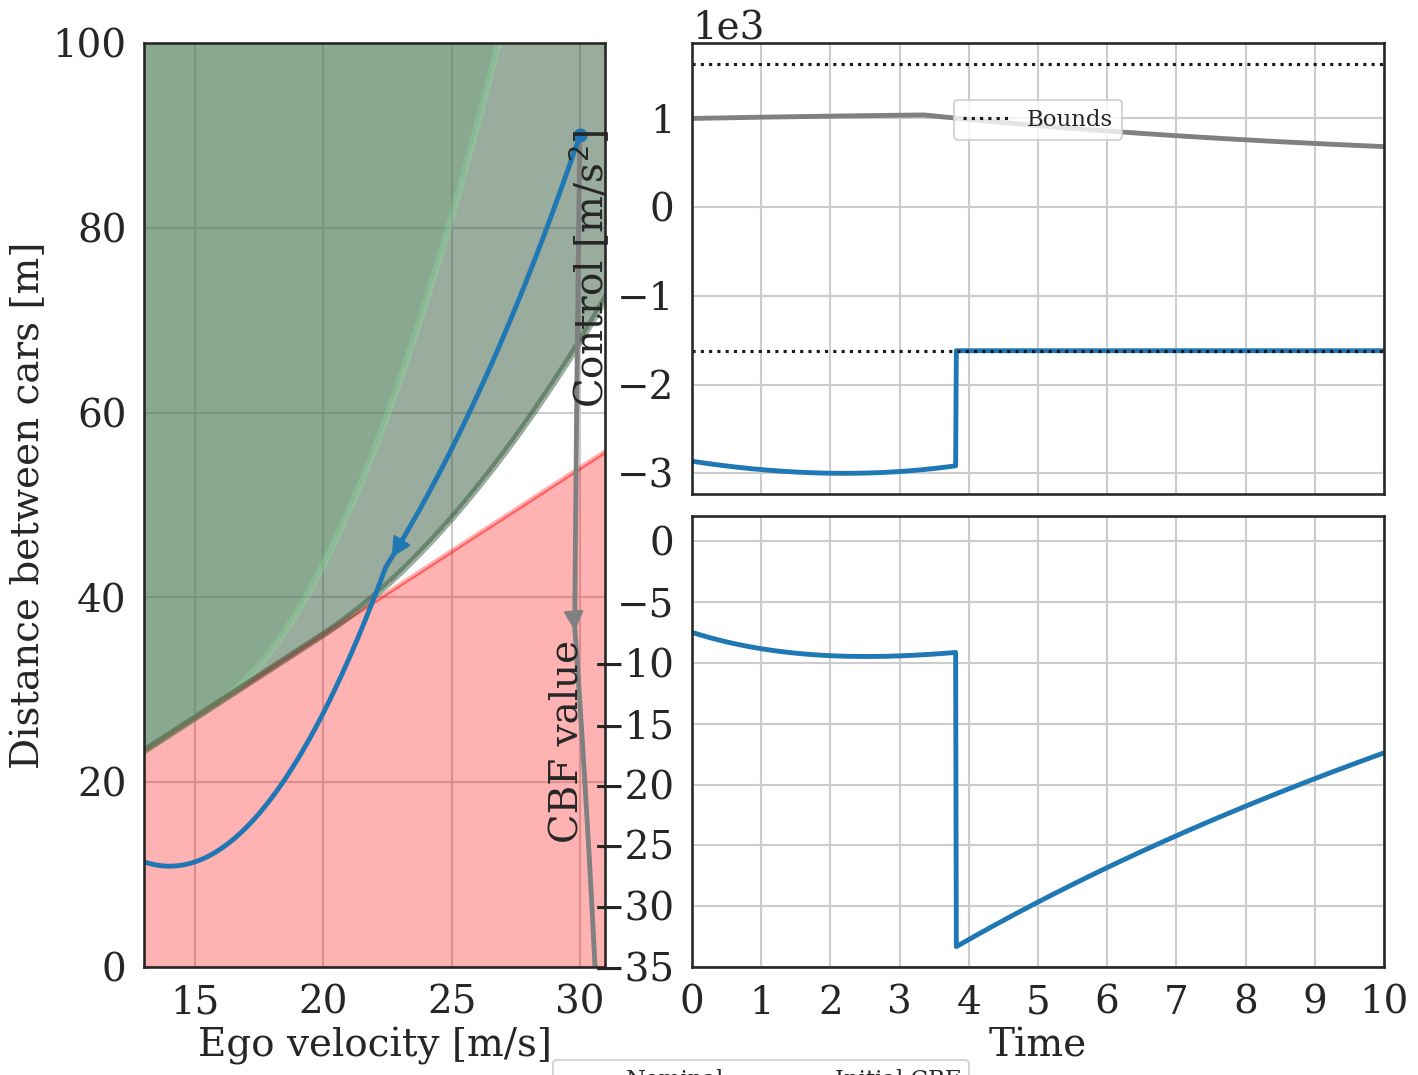

In [90]:
ts_experiment_addt = TimeSeriesExperiment('acc_example', x_indices=[], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)
ss_experiment_addt = StateSpaceExperiment('acc_example', x_indices=[1, 2], start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)



# fig, axs = plt.subplots(3, 1, sharex=False, figsize=(16, 12))
alt_colors = sns.color_palette("pastel", 9).as_hex()
# plt.subplots_adjust(hspace=0.0)
#make outer gridspec
fig = plt.figure(figsize=(16, 12))
colors = sns.color_palette("tab10")
outer = gridspec.GridSpec(1, 2, width_ratios= [2, 3], figure=fig, wspace=.15) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer[0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer[1], hspace = .05)
axs = []
for cell in gs1:
    axs += [plt.subplot(cell)]

for cell in gs2:
    axs += [plt.subplot(cell)]
    
axs = np.array(axs)
x = np.linspace(13, 31, 1000)
axs[0].fill_between(x, acc_cbf_dry.Th * x, alpha=0.3, color='red')
axs[0].plot(x, acc_cbf_dry.Th * x, color='red', alpha=.3)

# visualize safe invariant set for dry road
axs[0].contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[-1][20].T, levels=[0, 200], 
                alpha=0.3, colors=alt_colors[2])
axs[0].contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[-1][20].T, levels=[0], 
               colors=alt_colors[2], alpha=.3)

# visualize safe invariant set for ice road
axs[0].contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_ice[-1][20].T, levels=[0, 200], 
                alpha=0.3, colors=alt_colors[2])
axs[0].contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_ice[-1][20].T, levels=[0], 
               colors=alt_colors[2], alpha=.3)

# visualize safe invariant set for refined state space
axs[0].contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hybrid[-1][0].T, levels=[0, 200], 
                alpha=0.3, colors='black')
axs[0].contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hybrid[-1][0].T, levels=[0], 
               colors='black', alpha=.3)

fig_handle_ss = ss_experiment_addt.plot(acc_dry, paper_results, extra_measurements=['vf'], ax=axs[0], 
                                        color=chosen_colors, linestyles=['-', '-'])
fig_handle_ts = ts_experiment_addt.plot(acc_dry, paper_results, extra_measurements=['vf'], axs=axs[1:], 
                                        colors=chosen_colors, linestyles=['-', '-'])

plt.rcParams["font.family"] = "serif"
axs[1].get_shared_x_axes().join(axs[1], axs[2])
axs[0].set_xlabel("Ego velocity [m/s]")
axs[0].set_ylabel("Distance between cars [m]")
for ax in axs:
    for line in ax.lines:
        line.set_linewidth(3.5)



ts = axs[1].lines[0]._x

axs[1].set_ylabel("Control [m/s$^2$]")

axs[1].set_xticklabels([])

axs[0].set_ylim([0, 100])
axs[0].set_xlim([13, 31])

leg = axs[1].legend(["Nominal", "Initial CBF"], ncol=2, loc='center', bbox_to_anchor=(0.1, -1.3))    
axs[1].plot(ts, np.ones_like(ts) * umax_ice, ':k', label='Bounds')
axs[1].plot(ts, np.ones_like(ts) * umin_ice, ':k', label='__nolegend__')
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, .9))

axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[2].set_ylabel("CBF value")
axs[2].set_xlabel("Time")

axs[1].add_artist(leg)
axs[2].set_xticks(np.arange(0,11))
axs[1].set_xticks(np.arange(0,11))
#raise ValueError("stop")
for ax in axs:
    ax.grid(which='both')
for ax in axs[1:]:
    ax.set_xlim(ts[0], 10)

if save_figure:
    fig.savefig(figure_file_name, dpi=400, bbox_inches='tight')

In [59]:
video_file_name = "baseline-bad.gif"

In [60]:
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

c1='blue' 
c2='yellow' 
time_step_total = 55

In [91]:
# save data
with open("../../../dataset/acc-data/traj_all_bad.npy", "wb") as f:
    jnp.save(f, traj_all_bad)
with open("../../../dataset/acc-data/traj_all_good.npy", "wb") as f:
   jnp.save(f, traj_all_good)
with open("../../../dataset/acc-data/traj_all_global.npy", "wb") as f:
   jnp.save(f, traj_all_global)

In [92]:
with open("../../../dataset/acc-data/traj_all_bad.npy", "rb") as f:
    traj_all_bad = jnp.load(f)
with open("../../../dataset/acc-data/traj_all_good.npy", "rb") as f:
    traj_all_good = jnp.load(f)
with open("../../../dataset/acc-data/traj_all_global.npy", "rb") as f:
    traj_all_global= jnp.load(f)

In [93]:
pwd

'/home/shuo/shuo-research/papers/hybrid-cbf/hybrid-cbf/refineCBF/examples'

In [45]:
import matplotlib

In [94]:
method_index = 0 # 0 is vanilla, 1 is ours, 2 is global CBF

if method_index == 0:
    traj_all = traj_all_bad
elif method_index == 2:
    traj_all = traj_all_global
else:
    traj_all = traj_all_good

In [95]:
colors = sns.color_palette("tab10")
alt_colors = sns.color_palette("pastel", 9).as_hex()
toggle_hjr_visualization = False
save_video = True
video_file_name = "acc.gif"

MovieWriter ffmpeg unavailable; using Pillow instead.


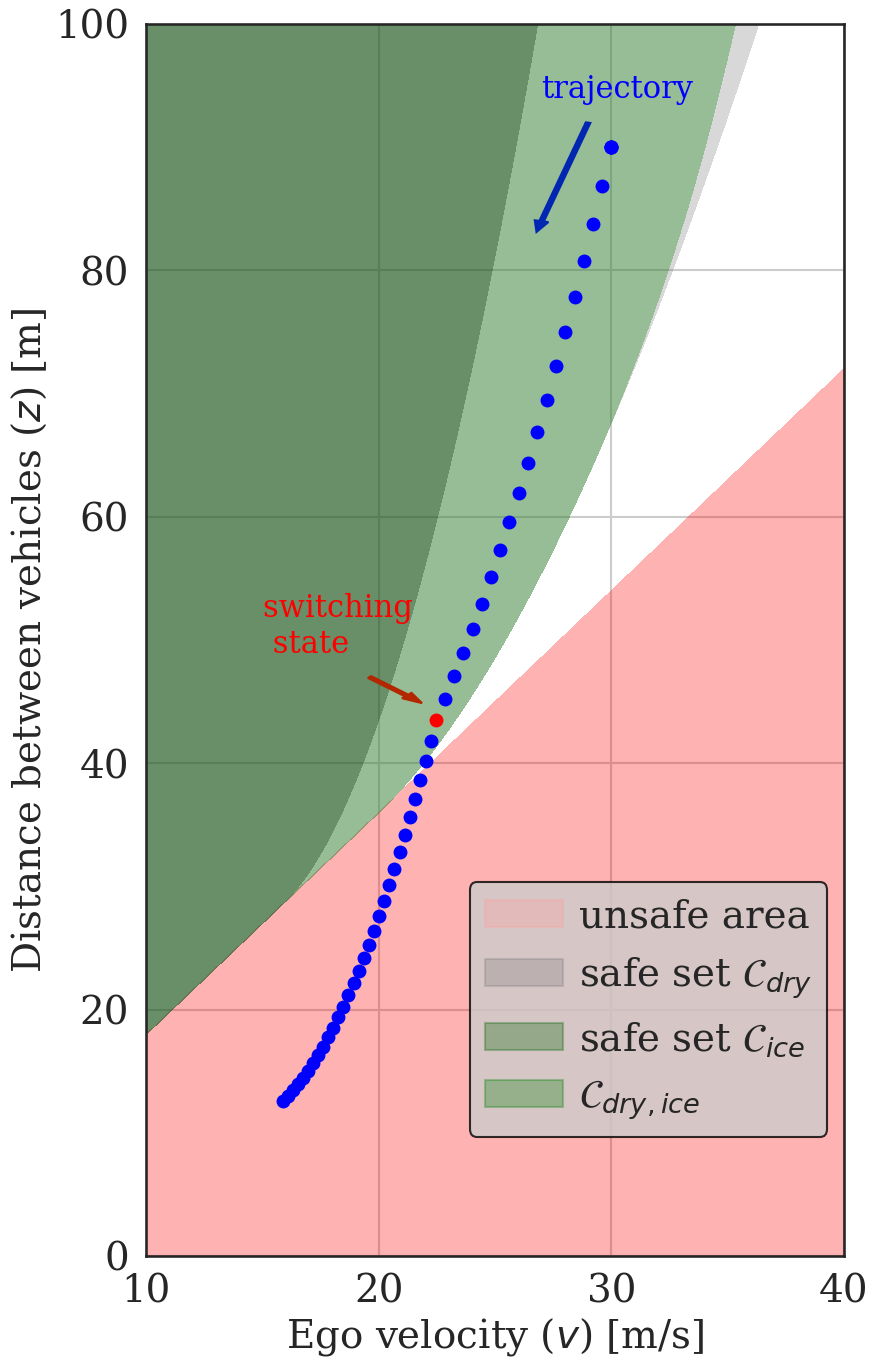

In [96]:
params = {'axes.labelsize': 28,'axes.titlesize':28, 'font.size': 28, 'legend.fontsize': 28, 
          'xtick.labelsize': 28, 'ytick.labelsize': 28, 'lines.linewidth': 5}
matplotlib.rcParams.update(params)

def render_frame(i, colorbar=False):
    global cont
    # global cont_new
    for c in cont.collections:
        c.remove()
    # timestamp.set_text("Time step = {}".format(i))

    if traj_all[i*20][0] >= switch_position - 2. and traj_all[i*20][0] <= switch_position + 2.:
        switch_index = i
        newpoint, = ax.plot(traj_all[i*20][1], traj_all[i*20][2], color="red", marker="o")
        ## for good traj
        if method_index == 1:
            ax.text(14, 50, 'switching \n state', fontsize = 22, color = 'red')
            ax.arrow(17,48, 1.6,-1.5,width=0.2, color = 'red')
        # for bad traj
        elif method_index == 0:
            ax.text(15, 49, 'switching \n state', fontsize = 22, color = 'red')
            ax.arrow(19.6,47, 1.6,-1.5,width=0.2, color = 'red')
        # for global CBF
        else:
            ax.text(12, 53, 'switching \n state', fontsize = 22, color = 'red')
            ax.arrow(16,52, 1.6,-1.5,width=0.2, color = 'red')

    else:
        newpoint, = ax.plot(traj_all[i*20][1], traj_all[i*20][2], color='blue', marker="o")
    
    if traj_all[i*20][0] >= switch_position + 0.5:
        cont = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_ice[-1][i].T, levels=[0, 200], 
                 colors='green', alpha=0.3)
    else:
        cont = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hybrid[-1][i].T, levels=[0, 200], 
                 colors='green', alpha=0.3)
    
    # cont = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hybrid[-1][i].T, levels=[0, 200], 
    #              colors='green', alpha=0.3)


    # if traj_all[i*20][0] >= switch_position - 2. and traj_all[i*20][0] <= switch_position + 2.:
    #     newpoint, = ax.plot(traj_all[i*20][1], traj_all[i*20][2], color="red", marker="o")
    #     print(traj_all[i*20][0])
    # else:
    #     newpoint, = ax.plot(traj_all[i*20][1], traj_all[i*20][2], color="blue", marker="o")
    # cont = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hybrid[-1][i].T, levels=[0, 200], 
    #              colors='green', alpha=0.3)
    
    # if toggle_hjr_visualization:
    #     global cont2
    #     for c in cont2.collections:
    #         c.remove()
    #     cont2 = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_hjr_dry[i][0].T, levels=[0],
    #                        colors=np.array([chosen_colors[0]]))
    

proxy = [] 

fig, ax = plt.subplots(figsize=(9, 16))

obstacle_viz = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], obstacle_dry[0].T, levels=[-100, 0], 
                 colors='red', alpha=0.3)


cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[-1][0].T, levels=[0, 200], 
                 colors='grey', alpha=0.3)

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_ice[-1][0].T, levels=[0, 200], 
                 colors='black', alpha=0.3)

cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[0][0].T, levels=[0], 
                  colors=np.array([colors[3]]))   # Initial CBF

proxy += [plt.Rectangle((0,0),1,1,ec =colors[3], fc='white', lw=5)
        for pc in cont.collections]

proxy += [plt.Rectangle((0,0),1,1,ec =colors[-1], fc='white', lw=5) for pc in cont.collections]

timestamp = ax.text(0.05, 0.9, "", transform=ax.transAxes)

# cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_dry[0][0].T, levels=[0], 
#                   colors=np.array([colors[-1]]))

# cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values_ice[-1][0].T, levels=[0], 
#                   colors='black')

ax.grid()
proxy2 = []
proxy2 += [plt.Rectangle((0,0),1,1,fc = alt_colors[3], ec=alt_colors[3], alpha=0.3)
        for pc in cs.collections]

proxy2 += [plt.Rectangle((0,0),1,1,fc = 'grey', ec='grey', alpha=0.3)
        for pc in cs.collections]

proxy2 += [plt.Rectangle((0,0),1,1, fc='darkgreen', ec='darkgreen', alpha=0.3) for pc in obstacle_viz.collections]

proxy2 += [plt.Rectangle((0,0),1,1, fc='green', ec='green', alpha=0.3) for pc in obstacle_viz.collections]

legend_entries = ["$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$"]
if toggle_hjr_visualization:
    legend_entries += ["$\partial \mathcal{C}_{\ell}(t)$"]
# leg = ax.legend(proxy, legend_entries,
#           loc='center', bbox_to_anchor=(0.5, 0.2), ncol=3, columnspacing=1.5, handletextpad=0.4,
#           facecolor=[0.8, 0.8, 0.8], edgecolor='black')

ax.arrow(29,92,-2,-8,width=0.2, color = 'blue')
ax.text(27, 94, 'trajectory', fontsize = 22, color = 'blue')

ax.legend(proxy2, ["unsafe area", "safe set $\mathcal{C}_{dry}$", "safe set $\mathcal{C}_{ice}$", "$\mathcal{C}_{dry, ice}$"],
          loc='center', bbox_to_anchor=(0.72, 0.2), ncol=1, columnspacing=1.5, handletextpad=0.4,
          facecolor=[0.8, 0.8, 0.8], edgecolor='black')

ax.set_ylabel("Distance between vehicles ($z$) [m]")
ax.set_xlabel("Ego velocity ($v$) [m/s]")

render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, 50, interval=200)
save_video = True
if save_video:
   animation.save(video_file_name, writer='ffmpeg')

In [ ]:
import moviepy.editor as mp

clip = mp.VideoFileClip(video_file_name)
clip.write_videofile("ours-good.mp4")

In [91]:
print(target_values_hybrid.shape[1])
print(traj_all_good.shape)

101
(2001, 3)


In [15]:
from numba import jit
import jax
import numba as nb

In [38]:
@jax.jit
def ident_np_jit(x):
    return jnp.cos(x) ** 2 + jnp.sin(x) ** 2

def ident_np(x):
    return jnp.cos(x) ** 2 + jnp.sin(x) ** 2

@jax.jit
def ident_loops_jit(x):
    r = jnp.empty_like(x)
    n = len(x)
    for i in range(n):
        r[i] = jnp.cos(x[i]) ** 2 + jnp.sin(x[i]) ** 2
    return r

def ident_loops(x):
    r = jnp.empty_like(x)
    n = len(x)
    for i in range(n):
        r[i] = jnp.cos(x[i]) ** 2 + jnp.sin(x[i]) ** 2
    return r

In [39]:
test_x = jnp.arange(0, 1000, 1)

In [ ]:
ident_np(test_x)

In [36]:
from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
  i = 0
  #while i < n:
  #  i += 1
  return x + i

In [37]:
%timeit g_jit_decorated(10, 20)

2.96 µs ± 10.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
